### Experiments setup

In [1]:
from sksurv.ensemble import RandomSurvivalForest
from pycox import datasets
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load dataset
from sksurv.datasets import load_veterans_lung_cancer
feats, surv_label_structarray = load_veterans_lung_cancer()
feat_cols = feats.columns.values
surv_label = np.array([surv_label_structarray["Survival_in_days"], 
                       surv_label_structarray["Status"]]).T

In [3]:
numeric_feat_cols = ["Age_in_years", "Months_from_Diagnosis", "Karnofsky_score"]
cate_feat_cols = [col for col in feat_cols if col not in numeric_feat_cols]

In [4]:
# Encode categorical features
from sklearn.preprocessing import OneHotEncoder
feats_new = feats[numeric_feat_cols]
feat_enc_cols = []
enc_dict = {}
for feat_col in cate_feat_cols:
    enc = OneHotEncoder(drop='if_binary')
    feat_new = enc.fit_transform(feats[feat_col].values.reshape((-1, 1))).toarray()
    feat_col_new = enc.get_feature_names_out([feat_col]).tolist()
    feats_new[feat_col_new] = feat_new
    feat_enc_cols.append(feat_col_new)
    enc_dict[feat_col] = enc
    
feats = feats_new
feat_cols = feats.columns.values

In [5]:
# Survival model to be explained
estimator = RandomSurvivalForest().fit(feats.values.astype(float), surv_label_structarray)

In [6]:
# Load model explainer
from src.explainer import explainer
eval_times = np.unique(surv_label[:, 0][surv_label[:, 1]==1])[:-1:5]
model_explainer = explainer(estimator, feats, surv_label, 
                            encoders=enc_dict, times=eval_times)

### Prediction

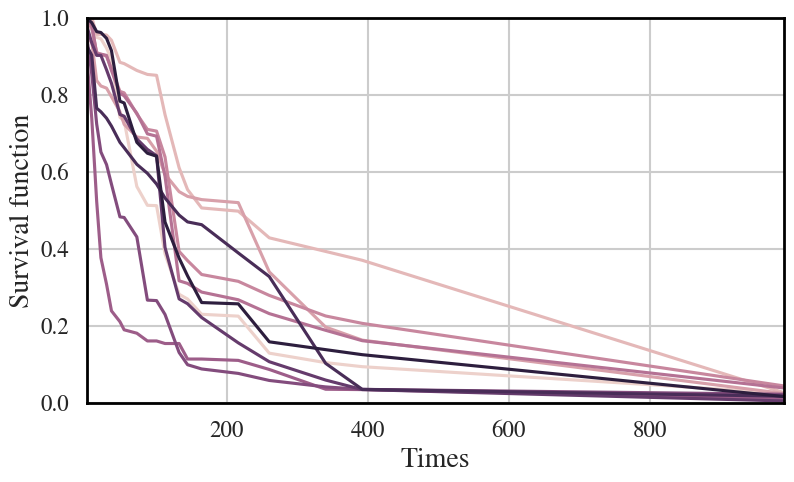

In [7]:
from src import prediction
# select first 10 observations to be explained
explained_data = feats[:10]
# Survival prediction
surv_pred = prediction.predict(model_explainer, explained_data, eval_times)
prediction.plot_prediction(surv_pred, "survival")

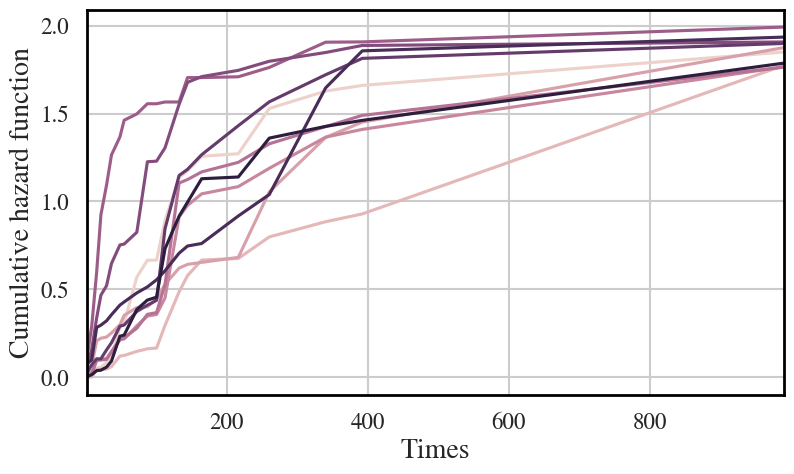

In [8]:
# Cumulative hazard prediction
chf_pred = prediction.predict(model_explainer, explained_data, eval_times, type="chf")
prediction.plot_prediction(chf_pred, "chf")

### Performance

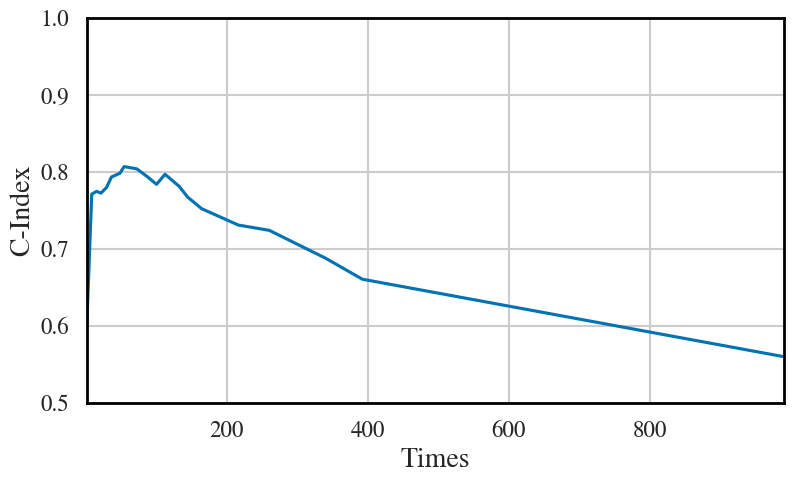

In [11]:
from src import performance
# C-Index evaluation
cindex_perf = performance.evaluate(model_explainer, feats, surv_label, metric="c_index")
performance.plot_performance(cindex_perf, metric="c_index", ylim=(0.5, 1.0))

In [12]:
print(cindex_perf.head(20))

    times      perf
0     1.0  0.600579
1     8.0  0.770672
2    15.0  0.774307
3    21.0  0.771922
4    29.0  0.779305
5    36.0  0.792935
6    48.0  0.797819
7    54.0  0.806452
8    72.0  0.803498
9    87.0  0.793276
10  100.0  0.783394
11  112.0  0.796456
12  132.0  0.780895
13  144.0  0.766924
14  164.0  0.751761
15  216.0  0.730520
16  260.0  0.723648
17  340.0  0.687415
18  392.0  0.660211
19  991.0  0.559462


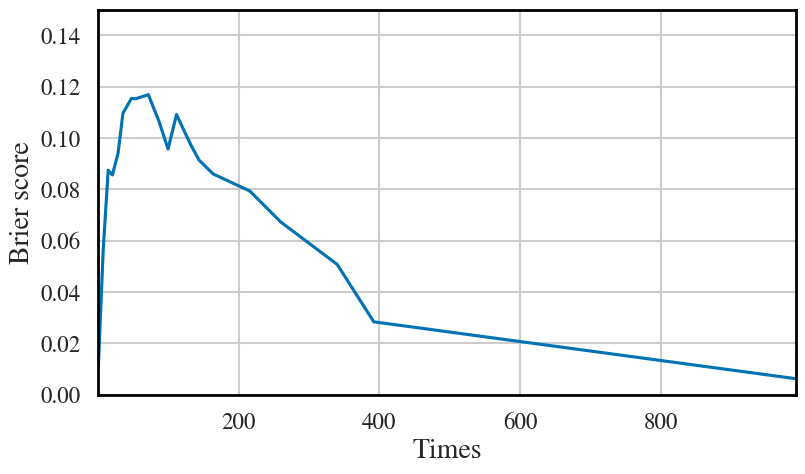

In [13]:
# Brier score evaluation
bs_perf = performance.evaluate(model_explainer, feats, surv_label, times=eval_times, metric="brier_score")
performance.plot_performance(bs_perf, metric="brier_score", ylim=(0,0.15))

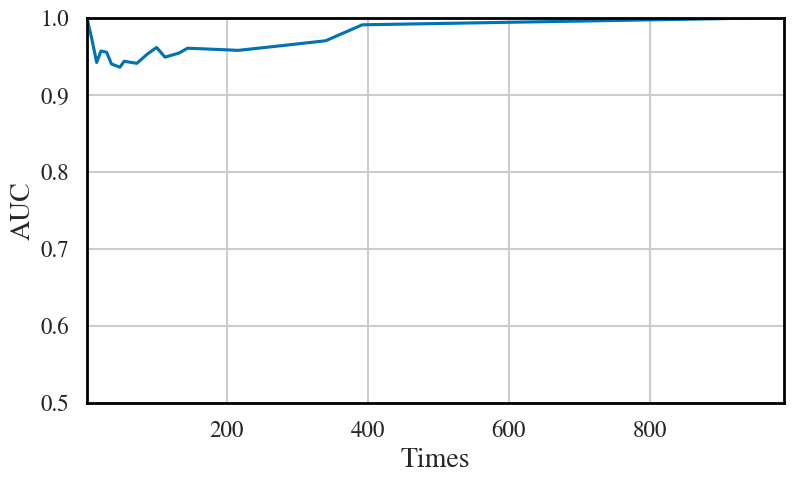

In [14]:
# AUC evaluation
auc_perf = performance.evaluate(model_explainer, feats, surv_label, times=eval_times, metric="auc")
performance.plot_performance(auc_perf, metric="auc", ylim=(0.5,1))

### Local explaination

In [15]:
from src import local_explaination

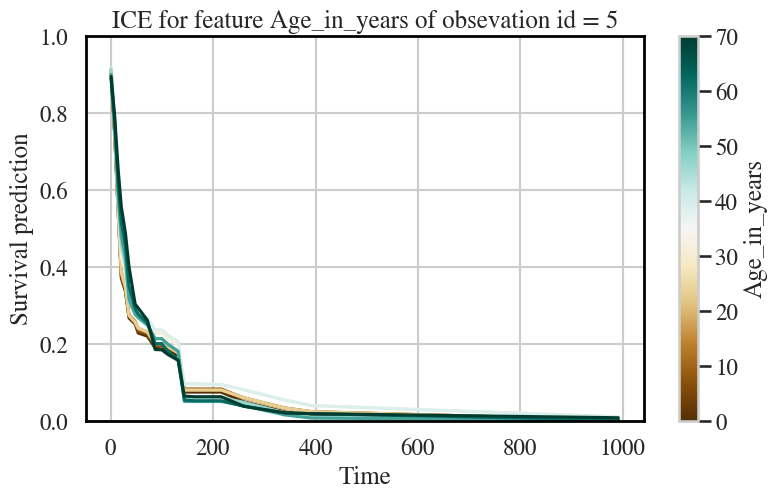

In [16]:
# individual conditional expectation
explained_feature = "Age_in_years"
ICE_df = local_explaination.individual_conditional_expectation(model_explainer, 
                                                               explained_feature, 
                                                               n_sel_samples=10, 
                                                               n_grid_points=10)
local_explaination.plot_ICE(model_explainer, ICE_df, explained_feature, id=5)

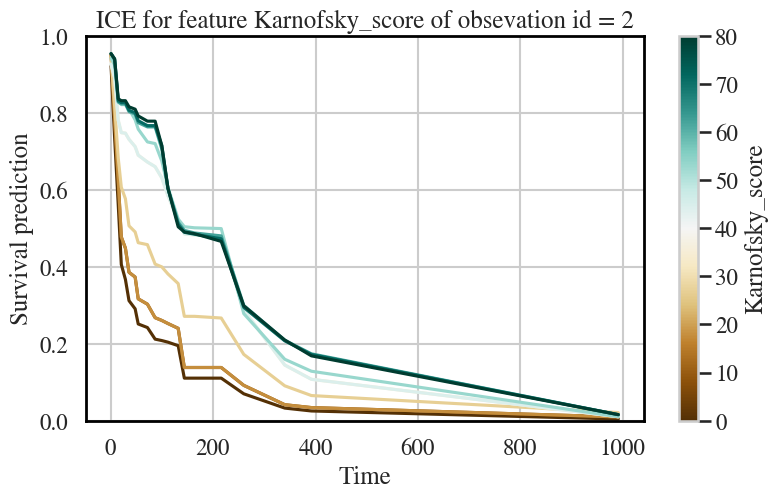

In [17]:
# individual conditional expectation
explained_feature = "Karnofsky_score"
ICE_df = local_explaination.individual_conditional_expectation(model_explainer, 
                                                               explained_feature, 
                                                               n_sel_samples=10, 
                                                               n_grid_points=10)
local_explaination.plot_ICE(model_explainer, ICE_df, explained_feature, id=2)

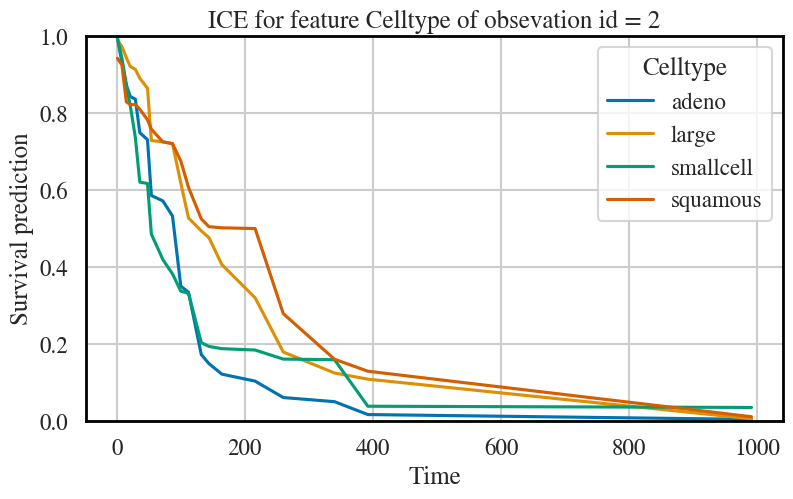

In [18]:
# individual conditional expectation
explained_feature = "Celltype"
ICE_df = local_explaination.individual_conditional_expectation(model_explainer, 
                                                               explained_feature, 
                                                               n_sel_samples=10, 
                                                               n_grid_points=10)

local_explaination.plot_ICE(model_explainer, ICE_df, explained_feature, id=2)

### Global explaination

In [19]:
from src import global_explaination

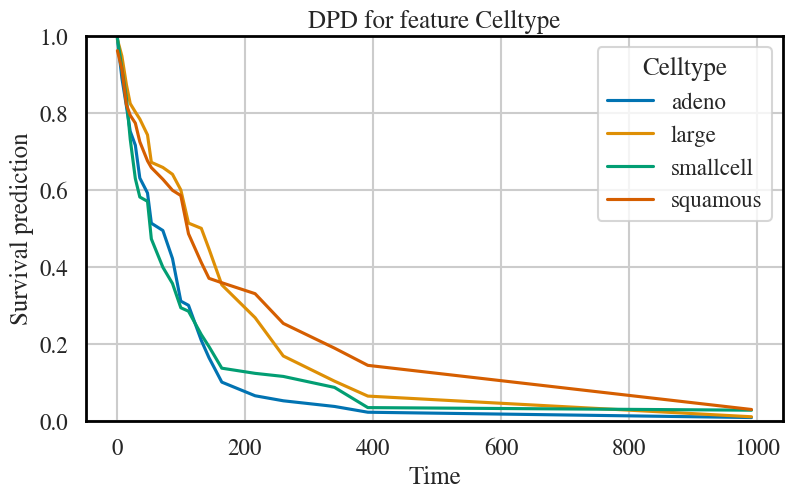

In [20]:
# partial dependence plot
explained_feature = "Celltype"
enc_sel = enc_dict[explained_feature]
PDP_df = global_explaination.partial_dependence_plots(model_explainer, 
                                                      explained_feature, 
                                                      n_sel_samples=100)
global_explaination.plot_PDP(model_explainer, PDP_df, explained_feature)

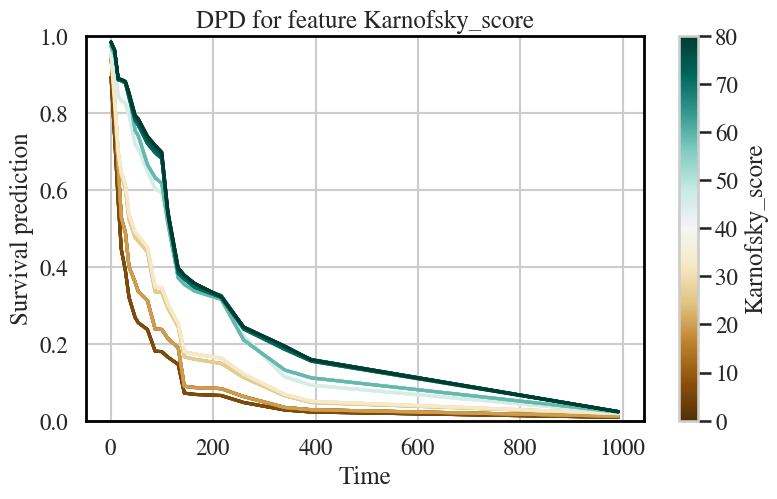

In [21]:
# partial dependence plot
explained_feature = "Karnofsky_score"
PDP_df = global_explaination.partial_dependence_plots(model_explainer, 
                                                      explained_feature, 
                                                      n_sel_samples=10)
global_explaination.plot_PDP(model_explainer, PDP_df, explained_feature)

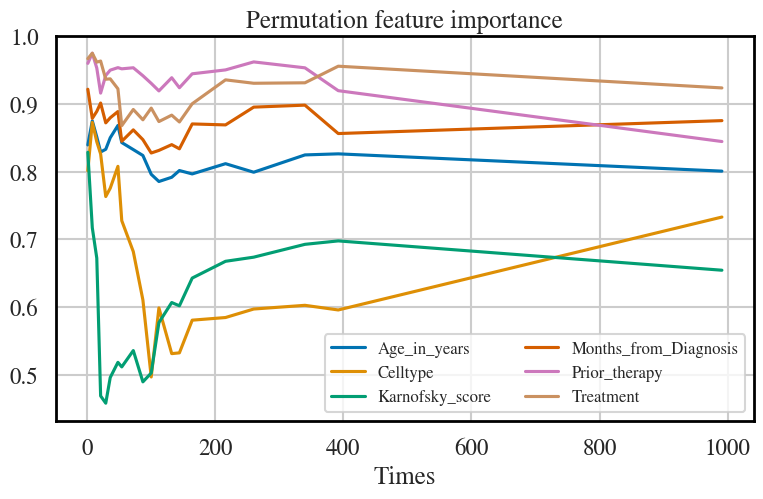

In [22]:
# permuatation feature importance
feat_importance_df = global_explaination.permutation_feature_importance(model_explainer, feats, 
                                                                        surv_label, n_perm = 3)
global_explaination.plot_PFI(feat_importance_df)